In [132]:
import pandas as pd
import unicodedata
import string
import re
import numpy as np
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
def find_between( s, first, last ):
    result = ''
    while True:
        try:
            start = s.index(first) + len(first)
            end = s.index( last, start )
            print(start, end)
            result += s[start:end] + ' '
            print(result)
            s = s[end:]
            print('made it')
        except ValueError:
            return result

def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""


bush = find_between(line, '<BUSH:>', '<')

In [135]:
parties = ['republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'republican', 'republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'democrat']
pres = ['bush', 'carter', 'clinton', 'eisenhower', 'fdroosevelt', 'ford', 'gwbush', 'hoover', 'kennedy', 'lbjohnson', 'nixon', 'obama', 'reagan', 'truman']
war = ['war', 'nw', 'nw', 'nw', 'war', 'nw', 'war', 'nw', 'war', 'war', 'war', 'war', 'nw', 'war']
pres_dict = {}
for i, v in enumerate(pres):
    pres_dict[v]= {}
    pres_dict[v]['party'] = parties[i]
    pres_dict[v]['war'] = war[i]
print(pres_dict['bush'])

{'party': 'republican', 'war': 'war'}


In [150]:
## imports .txt files and puts them into a dictionary
import os
data = []
for i, p in enumerate(pres):
    folder = 'corpus/' + p + '/'
    for filename in os.listdir(folder): 
        indiv = []
        indiv.append(p)
        indiv.append(parties[i])
        indiv.append(war[i])
        path = folder + filename
        if os.path.isfile(path) and filename.endswith(".txt"): 
            with open(path, "r") as file: 
                indiv.append(file.read())
            data.append(indiv)

#converts the dictionary to a dataframe
df = pd.DataFrame (data, columns = ['name', 'party', 'war','speech'])

### splits the speech into title, date, text
def get_text(x):
    idx = x.find('>', x.find('>')+1, 100)
    return x[idx+1:]

df['title'] = df['speech'].apply(lambda x: x.split('"')[1])
df['date'] = df['speech'].apply(lambda x: x.split('"')[3])
df['text'] = df['speech'].apply(get_text)

In [137]:
df.head()

,name,party,war,speech,title,date,text
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t..."
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...


In [151]:
def is_speech_type(string, speech_type):
    if string.lower().find(speech_type)>=0:
        return True
    else:
        return False

speech_type = ['interview', 'debate', 'inagural address', 'state of the union']
for i in speech_type:
    df[i] = df.title.apply(lambda x: is_speech_type(x, i))
df.head()

,name,party,war,speech,title,date,text,interview,debate,inagural address,state of the union
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False


In [159]:
debates = df[df['debate'] == True].reindex()

In [180]:
## debates on hold

for i, v in debates.iteritems():
    print(i, v, df.iloc[i, 'debate'])

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [166]:
bush_debate = df.iloc[5, :].text

In [176]:
def find_between( s, first, last ):
    result = ''
    while True:
        try:
            start = s.index(first) + len(first)
            end = s.index( last, start )
            result += s[start:end] + ' '
            s = s[end:]
        except ValueError:
            return result

def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""


bush = find_between(bush_debate, '<President Bush.>', '<')
df.loc[5, 'text'] = bush


In [177]:
df.loc[5, 'text']

' Well, I think one thing that distinguishes is experience. I think we\'ve dramatically changed the world. I\'ll talk about that a little bit later, but the changes are mind-boggling for world peace. Kids go to bed at night without the same fear of nuclear war. And change for change\'s sake isn\'t enough. We saw that message in the late seventies when we heard a lot about change. And what happened? That "misery index" went right through the roof. But my economic program, I think, is the kind of change we want. And the way we\'re going to get it done is we\'re going to have a brandnew Congress. A lot of them are thrown out because of all the scandals. I\'ll sit down with them, Democrats and Republicans alike, and work for my Agenda for American Renewal which represents real change. But I\'d say, if you had to separate out, I think it\'s experience at this level. \n\n  I just thought of another, another big difference here between me -- I don\'t believe Mr. Perot feels this way, but I kn

In [25]:
##EDA!!!

print(f'Speeches by president {df.name.value_counts()}')
print(f'speeches by party {df.party.value_counts()}')

Speeches by president lbjohnson      71
reagan         59
fdroosevelt    49
obama          48
kennedy        45
gwbush         39
clinton        39
hoover         29
bush           23
nixon          23
carter         22
truman         19
ford           14
eisenhower      6
Name: name, dtype: int64
speeches by party democrat      293
republican    193
Name: party, dtype: int64


In [ ]:
#3/7 of presidents are classified as "not war" (Hoover, Eisenhower, Ford, Carter, Reagan, Clinton).  
#These presidents have a disproportionate number of 1 term presidents, so their share of speeches are roughly
#proportional to their time in office
print(df['war'].value_counts())
print(169/486, 3/7)

In [28]:
# problem with labels name in this box!!!
%%
count_vector = CountVectorizer(stop_words='english', max_features=50)
X = count_vector.fit_transform(df.text)
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %
labels = count_vector.get_feature_names()
y_train = y_train.to_numpy()

## Initial Multinomial Bayes' run
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(f'Accuracy: {clf.score(X_test, y_test)}')
print(f'labels: {labels}')

NameError: name 'labels' is not defined

In [34]:
### adding features up to 200
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
# %

## takes vectorized tokens, target values, and labels for the 
def MNB(vector_array, y, labels):
    BoW = pd.DataFrame(vector_array.toarray(), columns=labels)
    X_train, X_test, y_train, y_test = train_test_split(BoW, y)
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    return (clf.predict(X_test), f'Accuracy: {clf.score(X_test, y_test)}')

print(MNB(X, df.party, labels))


(array(['republican', 'democrat', 'democrat', 'democrat', 'democrat',
       'democrat', 'republican', 'republican', 'democrat', 'republican',
       'democrat', 'republican', 'democrat', 'democrat', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'democrat', 'democrat', 'democrat', 'democrat', 'democrat',
       'democrat', 'republican', 'republican', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'democrat', 'democrat',
       'republican', 'democrat', 'democrat', 'democrat', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'republican', 'republican', 'democrat', 'republican', 'republican',
       'republican', 'democrat', 'republican', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       

In [ ]:
### adding features up to 200
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200, ngram_range = ((1,4)))
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

In [ ]:
clf.classes_

In [40]:
def get_top_features(feature_logs, labels, num_features):
    ## returns the top featurs for dems, republications, as well as the features that are unique to 
    #each party in the top num_features
    zero_all = np.array(labels)[np.argsort(feature_logs[0])[-1*num_features:]]
    one_all = np.array(labels)[np.argsort(feature_logs[1])[-1*num_features:]]
    zero_unique = [x for x in zero_all if x not in one_all]
    one_unique = [x for x in one_all if x not in zero_all]
    return zero_all, one_all, zero_unique, one_unique
    
    

## the most important features for each class after the 200 word, 3 n-gram
get_top_features(clf.feature_log_prob_, labels, 50)


(array(['help', 'day', '``', 'believe', 'good', 'job', 'also', 'let',
        'great', 'way', 'need', 'last', 'first', 'today', "''", 'want',
        'many', 'united state', 'applause', "'ve", 'congress', 'peace',
        'work', 'know', 'right', 'war', 'every', 'united', 'america',
        'make', 'think', 'government', 'mr', 'new', "n't", 'must', 'time',
        'one', 'country', 'state', 'world', 'nation', 'u', 'would',
        'president', 'year', 'american', 'people', "'s", '--'],
       dtype='<U15'),
 array(['soviet', 'need', 'way', 'today', 'want', 'freedom', 'first',
        'say', 'let', 'force', 'well', 'think', 'right', 'every', 'work',
        'tax', 'many', '``', 'congress', 'great', 'life', "'re", 'make',
        'united state', 'war', "''", 'know', 'mr', "'ve", 'peace',
        'united', 'country', 'new', "n't", 'time', 'must', 'america',
        'one', 'would', 'state', 'nation', 'president', 'government',
        'world', 'year', 'u', 'american', 'people', '--', "'s"]

In [ ]:
print(f'Top words for democrats{np.array(labels)[last_5[:15]]}')
print(f'Top unique words for republicans{np.array(labels)[last_class_1[:15]]}')

In [ ]:
print(labels)

In [ ]:
#### Tokenizer from sklearn
from nltk import word_tokenize
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
vect = CountVectorizer(tokenizer=LemmaTokenizer())  

In [ ]:
### adding features up to 200, 3-grams, lemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%

count_vector = CountVectorizer(max_features=200, ngram_range = ((1,4)), tokenizer=WordNetLemmatizer())
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

In [100]:
sw = stopwords.words('english')

In [49]:
## lemmatized

from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
sw = stopwords.words('english')
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = df['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['democrat' 'republican' 'democrat' 'republican' 'republican' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'republican' 'republican' 'republican' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'republican' 'democrat' 'republican' 'republican' 'republican'
 'republican' 'democrat' 'republican' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'repu

In [43]:
zero, one, zero_uniqe, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero}')
print(f'one unique: {one}')

zero: ['help' 'day' '``' 'believe' 'good' 'job' 'also' 'let' 'great' 'way'
 'need' 'last' 'first' 'today' "''" 'want' 'many' 'united state'
 'applause' "'ve" 'congress' 'peace' 'work' 'know' 'right' 'war' 'every'
 'united' 'america' 'make' 'think' 'government' 'mr' 'new' "n't" 'must'
 'time' 'one' 'country' 'state' 'world' 'nation' 'u' 'would' 'president'
 'year' 'american' 'people' "'s" '--']
one: ['soviet' 'need' 'way' 'today' 'want' 'freedom' 'first' 'say' 'let'
 'force' 'well' 'think' 'right' 'every' 'work' 'tax' 'many' '``'
 'congress' 'great' 'life' "'re" 'make' 'united state' 'war' "''" 'know'
 'mr' "'ve" 'peace' 'united' 'country' 'new' "n't" 'time' 'must' 'america'
 'one' 'would' 'state' 'nation' 'president' 'government' 'world' 'year'
 'u' 'american' 'people' '--' "'s"]
zero unique: ['help' 'day' '``' 'believe' 'good' 'job' 'also' 'let' 'great' 'way'
 'need' 'last' 'first' 'today' "''" 'want' 'many' 'united state'
 'applause' "'ve" 'congress' 'peace' 'work' 'know' 'right' 'wa

In [104]:
stop = sw
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [112]:

new_sw = ['also', 'day','say', 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    stop.append(i)


In [106]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [50]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = df['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['republican' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'democrat' 'republican' 'democrat'
 'democrat' 'republican' 'democrat' 'republican' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'republican'
 'democrat' 'republican' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'democrat' 'republican' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'republica

In [98]:
flatten = lambda sw: [item for sublist in sw for item in sublist]

In [99]:
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [128]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in stop and token not in pt]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

def run_mnb(ngrams = 3, max_features = 500):
    token_array = df['text'].apply(doc_to_tokens)

    ## stores tokens in dictionary
    custom_tokens = {}
    for i,v in enumerate(token_array.to_numpy()):
        custom_tokens[i] = v

    ## initializes CV with given tokens and runs MNB prediction
    tfidf = TfidfVectorizer(
    # so we can pass it strings
        input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
        lowercase=False,
        preprocessor=lambda x: x,
        max_features = 700,
        ngram_range = ((1,3)),
    # use our token dictionary
        tokenizer=lambda key: custom_tokens[key])

    X = tfidf.fit_transform(custom_tokens.keys())
    labels = tfidf.get_feature_names()
# %%
    BoW = pd.DataFrame(X.toarray(), columns=labels)
    X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return clf, score
clf, score = run_mnb()

0.680327868852459

In [130]:
feat = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]
scores = []
for i in feat:
    _, score = run_mnb(max_features = feat)
    scores.append(score)
    

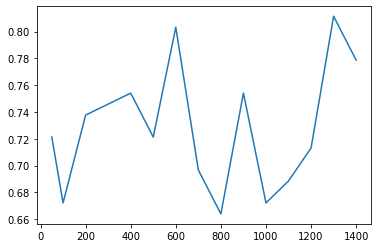

In [134]:
fig, ax = plt.subplots()
ax.plot(feat, scores)

In [129]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero_unique}')
print(f'one unique: {one_unique}')

zero: ['problem' 'high' 'present' 'different' 'distinguished' 'goal' 'issue'
 'border' 'le' 'peaceful' 'congress' 'get' 'food' 'ensure'
 'fellow american' 'armed' 'economic growth' 'historic' 'even' 'better'
 "'ve" 'destruction' 'freedom' 'press' 'difficult' 'effective' 'candidate'
 'provide' 'giving' 'poor' 'greatest' 'financial' 'man' 'help' 'part'
 'education' 'ahead' 'agency' 'hope' 'information' 'political' 'path'
 'pressure' 'cause' 'job' 'needed' 'purpose' 'hemisphere' 'aggression'
 'instead']
one: ['ahead' 'policy' 'economic growth' 'help' 'different' 'abroad' 'food'
 'peaceful' 'get' 'high' 'present' 'better' 'men' 'official'
 'distinguished' 'historic' 'problem' 'man' 'ensure' 'kind' 'conduct'
 'federal' 'giving' 'financial' 'destruction' 'poor' 'provide' 'pressure'
 'freedom' 'effective' 'difficult' 'candidate' 'decision' 'opinion' "'re"
 'political' 'job' 'cause' 'much' 'path' "'ve" 'hope' 'information'
 'needed' 'hemisphere' 'education' 'agency' 'purpose' 'aggression'
 'in